<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]"
IPython,7.21.0
MatPlotLib,3.3.4
Numpy,1.20.1
pyAgrum,0.19.3.9


# Credal Net from BN

In [35]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
  bn_min.cpt(n).scale(0.9)
  bn_max.cpt(n).scale(1.1)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.sideBySide(bn.cpt("B"),bn_min.cpt("B"),bn_max.cpt("B"))
cn

(gum::credal::CredalNet<double>@000002BB66A79E50) 
A[0,1]
<> : [[0.462493 , 0.537507] , [0.560222 , 0.439778]]

B[0,2]
<A:0> : [[0.262806 , 0.231398 , 0.505796] , [0.262806 , 0.272997 , 0.464197] , [0.313169 , 0.272997 , 0.413834] , [0.321207 , 0.264959 , 0.413834] , [0.270844 , 0.223361 , 0.505796] , [0.321207 , 0.223361 , 0.455432]]
<A:1> : [[0.0720461 , 0.34895 , 0.579004] , [0.0880579 , 0.34895 , 0.562992] , [0.0720461 , 0.426494 , 0.50146] , [0.0880579 , 0.426494 , 0.485448]]

C[0,1]
<B:0|D:0> : [[0.387933 , 0.612067] , [0.47414 , 0.52586]]
<B:1|D:0> : [[0.710351 , 0.289649] , [0.763014 , 0.236986]]
<B:2|D:0> : [[0.335287 , 0.664713] , [0.409794 , 0.590206]]
<B:0|D:1> : [[0.52037 , 0.47963] , [0.607576 , 0.392424]]
<B:1|D:1> : [[0.295521 , 0.704479] , [0.361192 , 0.638808]]
<B:2|D:1> : [[0.865578 , 0.134422] , [0.890017 , 0.109983]]

D[0,1]
<A:0> : [[0.402787 , 0.597213] , [0.492293 , 0.507707]]
<A:1> : [[0.453152 , 0.546848] , [0.552579 , 0.447421]]

E[0,1]
<A:0> : [[0.353014 , 0.646986] , [0.431461 , 0.568539]]
<A:1> : [[0.969012 , 0.0309883] , [0.974646 , 0.0253542]]

F[0,1]
<E:0> : [[0.642667 , 0.357333] , [0.707635 , 0.292365]]
<E:1> : [[0.519432 , 0.480568] , [0.606808 , 0.393192]]

#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [36]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeBinaryCPTMinMax()

gnb.sideBySide(cn,cn2)

Here, $B$ becomes 
- $B$-b$i$ : the $i$-th bit of B
- instrumental $B$-v$k$ : the indicator variable for each modality $k$ of $B$

In [39]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

In [40]:
gnb.sideBySide(gnb.getInference(cn,ie_mc),gnb.getInference(cn2,ie2_mc),gnb.getInference(cn2,ie2_lbp))

In [7]:
gnb.sideBySide(ie_mc.CN(),ie_mc.marginalMin("F"),ie_mc.marginalMax("F"))
gnb.sideBySide(ie_mc.CN(),ie2_lbp.marginalMin("F"),ie2_lbp.marginalMax("F"))

## Credal Net from bif files

In [9]:
cn=gum.CredalNet(os.path.join("res","cn/2Umin.bif"),os.path.join("res","cn/2Umax.bif"))
cn.intervalToCredal()

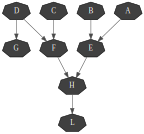

In [10]:
gnb.showCN(cn,"2")

In [11]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile(os.path.join("res","cn/L2U.evi"))

In [12]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [13]:
gnb.sideBySide(cn,gnb.getInference(cn,targets={"A","H","L","D"},engine=ie,evs={"L":[0,1],"G":[1,0]}))

# Comparing inference in credal networks

In [15]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)[:]
        c,d=mc.marginalMax(i)[:]
        
        e,f=lbp.marginalMin(i)[:]
        g,h=lbp.marginalMax(i)[:]
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()

#### The two inference give quite the same result

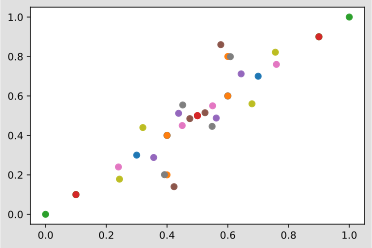

In [17]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

cn.computeBinaryCPTMinMax()
ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

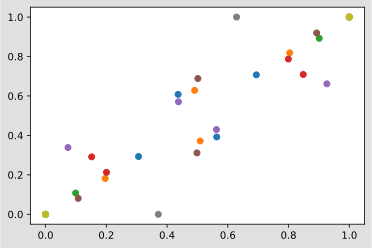

In [18]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [19]:
cn=gum.CredalNet(os.path.join("res","cn/bn_c_8.bif"),os.path.join("res","cn/den_c_8.bif"))
cn.bnToCredal(0.8,False)

In [20]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(True)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()

In [21]:
print(ie.dynamicExpMax("temp"))

(13.796595325898947, 11.391276171798012, 11.880707481299204, 11.845957195973266, 11.832343590421114, 11.838440247998115, 11.837182337197266, 11.83727595089036, 11.837309606952806)


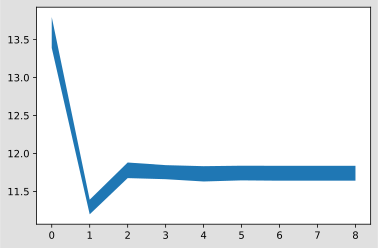

In [22]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [23]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()


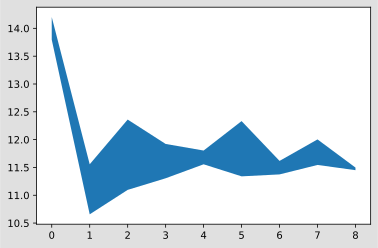

In [24]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

stopped with epsilon=0


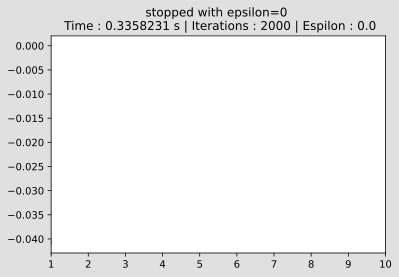

In [25]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(5000)

gnb.animApproximationScheme(ie)
ie.makeInference()
print(ie.messageApproximationScheme())

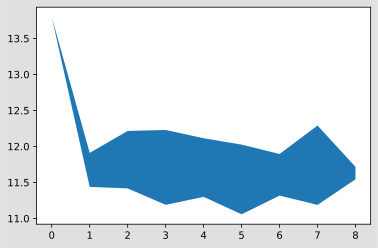

In [26]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));